In [47]:
#imports
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt




## Data augmentation

In [27]:
data_aug = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456,0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([ 
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456,0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
data_path = 'dataset'

#Data Loaders
img_dataset = {}
for x in ['train', 'test']:
    img_dataset[x] = datasets.ImageFolder(os.path.join(data_path, x), data_aug[x])

dataloaders = {}

for x in ['train','test']:
    dataloaders[x] = torch.utils.data.DataLoader(img_dataset[x],batch_size = 4,shuffle=True,num_workers=2)

dataset_sizes = {}

for x in ['train','test']:
    dataset_sizes[x] = len(img_dataset[x])
print(dataset_sizes)

label_names = img_dataset['train'].classes
label_names


## TransferLearning

In [29]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)


#freezing the layers except for the final one for the  classification

for name, param in model.named_parameters():
    if 'fc' in name:
        param.requires_grad =True
    else:
        param.requires_grad =False

loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

device = 'cpu'

model = model.to(device)

## Training

In [31]:
epochs = 20

for epoch in range(epochs):
    for phase in ['train', 'test']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()  # Set model to evaluation mode (fixing model.test() to model.eval())

        running_loss = 0.0
        running_corrects = 0

        for imgs, labels in dataloaders[phase]:
            imgs = imgs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'): 
                outputs = model(imgs)
                _, preds = torch.max(outputs, 1)  
                loss = loss_func(outputs, labels)  

                if phase == 'train':
                    loss.backward()  
                    optimizer.step()  

            running_loss += loss.item() * imgs.size(0)  
            running_corrects += torch.sum(preds == labels.data)  

        epoch_loss = running_loss / dataset_sizes[phase]  
        epoch_acc = running_corrects.double() / dataset_sizes[phase]  

        print(f"{phase} - Epoch {epoch+1}/{epochs}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_acc:.4f}")

print("Model Trained")


train - Epoch 1/20: Loss = 1.2550, Accuracy = 0.6553
test - Epoch 1/20: Loss = 0.1657, Accuracy = 0.9500
train - Epoch 2/20: Loss = 0.5425, Accuracy = 0.7989
test - Epoch 2/20: Loss = 0.1377, Accuracy = 0.9429
train - Epoch 3/20: Loss = 0.5518, Accuracy = 0.8079
test - Epoch 3/20: Loss = 0.1645, Accuracy = 0.9429
train - Epoch 4/20: Loss = 0.5043, Accuracy = 0.8151
test - Epoch 4/20: Loss = 0.2608, Accuracy = 0.9214
train - Epoch 5/20: Loss = 0.5360, Accuracy = 0.7953
test - Epoch 5/20: Loss = 0.1608, Accuracy = 0.9357
train - Epoch 6/20: Loss = 0.4855, Accuracy = 0.7989
test - Epoch 6/20: Loss = 0.1947, Accuracy = 0.9071
train - Epoch 7/20: Loss = 0.4682, Accuracy = 0.8079
test - Epoch 7/20: Loss = 0.1130, Accuracy = 0.9714
train - Epoch 8/20: Loss = 0.5654, Accuracy = 0.7882
test - Epoch 8/20: Loss = 0.4211, Accuracy = 0.8714
train - Epoch 9/20: Loss = 0.5771, Accuracy = 0.7971
test - Epoch 9/20: Loss = 0.3813, Accuracy = 0.8643
train - Epoch 10/20: Loss = 0.5582, Accuracy = 0.7935
t

In [43]:
torch.save(model.state_dict(), 'model.pth')

## Classifying New Images

In [58]:
model = models.resnet18(pretrained=True)

model.fc = nn.Linear(model.fc.in_features, 2)


checkpoint = torch.load('model.pth')

checkpoint = {k: v for k, v in checkpoint.items() if 'fc' not in k}
model.load_state_dict(checkpoint, strict=False)

model.eval()  

# Preprocessing the unseen image
unseen_img = 'unseen1_cat.png'  
img = Image.open(unseen_img).convert("RGB")  # Convert to RGB

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Apply transformations
input_tensor = preprocess(img)
input_batch = input_tensor.unsqueeze(0)  

# Inference
with torch.no_grad():  
    output = model(input_batch)


_, predicted_class = output.max(1)


img_label = ['dogs', 'cats']
predicted_label = img_label[predicted_class.item()]

print(f"Predicted label: {predicted_label}")

Predicted label: cats


## Displaying the Image

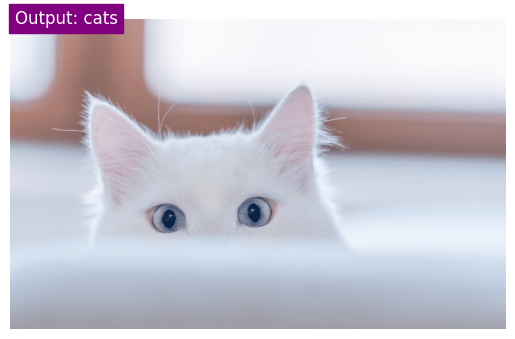

In [59]:
img = np.array(img)
plt.imshow(img)
plt.axis('off')
plt.text(10,10,f'Output: {predicted_label}',fontsize = 12, color = 'white',backgroundcolor='purple')
plt.show()